In [18]:
import matplotlib.pyplot as plt
import numpy as np
from lattice import Triangular_Lattice 
from sklearn.manifold import TSNE
from utils import *
from walker import Graphene_Walker
import seaborn as sns
%load_ext autoreload
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
temperatures = range(4,10)
periodicity = [16]

period_temp_activations = []
period_temp_predictions = []
period_temp_values = []
period_num_fbm = []
period_num_brownian = []
period_num_ctrw = []
 

for period in periodicity:
    all_temp_activations = []
    all_temp_predictions = []
    all_temp_values = []
    num_fbm = []
    num_brownian = []
    num_ctrw = []
    for temp in temperatures:
        
        ## generate tracks at that temperature
        moire = Triangular_Lattice(period, 2) # 16nm lattice constant, 1meV energy amplitude
        walkers = Graphene_Walker(0.246, temp) # 2.46 Angstrom lattice, 10 Kelvin
        tracks = walkers.get_tracks(moire, nsteps=50, njumps=100000, nparticles=400, endT=1e5)

        ## gather x and y values
        x = []
        y = []
        for particle in list(set(tracks['particle'])):
            x.append(np.array(tracks[tracks['particle'] == particle]['x']))
            y.append(np.array(tracks[tracks['particle'] == particle]['y']))
        x = np.array(x)
        y = np.array(y)

        ## calculate dx and y
        temp_x = x-np.mean(x)
        temp_dx = np.diff(temp_x)
        temp_dx = temp_dx/np.std(temp_dx)

        print(temp_dx)
        ## trim x and y to shape
        temp_dx = temp_dx[:,::int(temp_dx.shape[1] / 50)][:,:-1]

        temp_values, temp_predictions = classification_on_real(temp_dx)
        all_temp_activations.append(get_activations(temp_dx))

        num_fbm.append(sum([1 for idx, x in temp_predictions if x == 0]))
        num_brownian.append(sum([1 for idx, x in temp_predictions if x == 1]))
        num_ctrw.append(sum([1 for idx, x in temp_predictions if x == 2]))

        all_temp_predictions.append(temp_predictions)
        all_temp_values.append(temp_values)
    period_temp_activations.append(all_temp_activations)
    period_temp_predictions.append(all_temp_predictions)
    period_temp_values.append(all_temp_values)
    period_num_fbm.append(num_fbm)
    period_num_brownian.append(num_brownian)
    period_num_ctrw.append(num_ctrw)
    
all_temp_activations = np.array(all_temp_activations)
all_temp_activations = all_temp_activations.reshape((all_temp_activations.shape[0], 
                                                     all_temp_activations.shape[1],
                                                     all_temp_activations.shape[3]))

[[ 2.91927329  3.55786432  0.09122729 ...  0.27368187 -0.27368187
  -0.63859103]
 [-0.27368187 -1.45963664 -0.54736374 ... -0.18245458  0.
   0.72981832]
 [ 3.83154619  1.55086393  0.9122729  ... -0.54736374  0.
   0.        ]
 ...
 [-4.47013722  0.36490916 -0.09122729 ... -0.09122729  0.
  -0.72981832]
 [ 2.18945497 -4.47013722  4.47013722 ...  0.27368187  0.54736374
  -0.45613645]
 [ 4.92627367  0.          0.82104561 ...  0.09122729  0.
   0.82104561]]
[[ 1.87704701 -0.36097058  1.94924113 ... -0.86632939  0.
  -0.36097058]
 [-3.89848226 -0.72194116 -0.14438823 ...  1.22729997  0.21658235
   0.86632939]
 [ 5.55894693  0.72194116 -1.15510586 ...  0.72194116  0.14438823
   0.        ]
 ...
 [-5.05358812 -1.29949409 -0.57755293 ... -0.4331647   0.28877646
  -0.07219412]
 [-1.3716882   1.29949409  0.21658235 ...  0.28877646 -0.50535881
  -0.36097058]
 [ 1.01071762 -1.94924113  1.3716882  ...  0.72194116  0.86632939
  -1.15510586]]
[[ 0.73752656 -0.24584219 -0.12292109 ... -2.0896586   0

In [16]:
def manifold(dx, predictions, s=30, ax=None, markers = ["o",">","s"], color="tab:blue", fbm_coeffs=None, ctrw_alphas=None, embedding_name="tsne"):
    if embedding_name == "tsne":
        embedded_dx = TSNE(init="pca", random_state=12345).fit_transform(dx)
    else:
        embedded_dx = TSNE(init="pca", random_state=12345).fit_transform(dx)
    
    fbm_points = np.array([x for idx, x in enumerate(embedded_dx) if predictions[idx][1] == 0])
    ctrw_points = np.array([x for idx, x in enumerate(embedded_dx) if predictions[idx][1] == 2])
    brownian_points = np.array([x for idx, x in enumerate(embedded_dx) if predictions[idx][1] == 1])

    fbm = None
    ctrw = None
    brownian = None
    plt_list = []
    plt_names = []
    if ax is None:
        ax = plt.axes()
        ax.figure.set_size_inches(12,8)
    if fbm_points.size != 0:
        if fbm_coeffs is not None:
            cmap = sns.cubehelix_palette(as_cmap=True)
            fbm = ax.scatter(fbm_points[:,0], fbm_points[:,1], s=s, 
                             c=fbm_coeffs*2,marker=markers[0], edgecolors='black',cmap=cmap)
        else:
            fbm = ax.scatter(fbm_points[:,0], fbm_points[:,1], s=s, c=color,marker=markers[0], edgecolors='black')
        plt_list.append(fbm)
        plt_names.append("fbm")
    if ctrw_points.size != 0:
        if ctrw_alphas is not None:
            cmap = sns.cubehelix_palette(as_cmap=True, rot=-0.4)
            ctrw = ax.scatter(ctrw_points[:,0], ctrw_points[:,1], s=s, 
                              c=ctrw_alphas, marker=markers[1], edgecolors='black', cmap=cmap)
        else:
            ctrw = ax.scatter(ctrw_points[:,0], ctrw_points[:,1], s=s, c=color, marker=markers[1], edgecolors='black')
        plt_list.append(ctrw)
        plt_names.append("ctrw")
    if brownian_points.size != 0:
        brownian = ax.scatter(brownian_points[:,0], brownian_points[:,1], s=s, c=color, marker=markers[2],edgecolors='black')
        plt_list.append(brownian)
        plt_names.append("brownian")

    plt.legend(plt_list, plt_names)
    return ctrw, ax

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

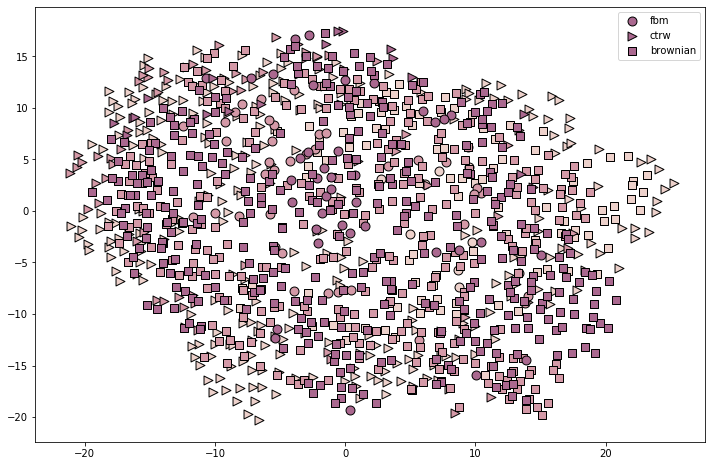

In [22]:
marker_size = 80
colors = sns.cubehelix_palette(9)
ctrw1, ax = manifold(all_temp_activations[0], all_temp_predictions[0], s = marker_size, color=colors[0])
ctrw2, ax = manifold(all_temp_activations[2], all_temp_predictions[2], s = marker_size, ax=ax, color=colors[2])
ctrw3, ax = manifold(all_temp_activations[4], all_temp_predictions[4], s = marker_size, ax=ax, color=colors[4])

In [29]:
%autoreload 2
import umap

ModuleNotFoundError: No module named 'umap'